# EMG recording
## Experiment 1: Large muscle experiment with dry and wet electrode

In [2]:
import wave
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal

In [3]:
def read_wave(file_name):
    file = wave.open(file_name,'rb')
    params = file.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    print("nchannels:", nchannels)
    print("sampwidth:", sampwidth)
    print("framerate:", framerate)
    print("nframes:", nframes)
    strData = file.readframes(nframes)  # encoded in bytes
    file.close()
    waveData = np.frombuffer(strData, dtype=np.int16)  # convert to int16
    return waveData, framerate, nframes

### some common normalization methods
#### (1) set maximun as 1/-1
    by_max: signal / (np.max(np.abs(signal)))
#### (2) set full range from 0-1
    01: (signal - np.min(signal)) / (np.max(signal)-np.min(signal))
#### (3) subtract mean, divided by standard deviation
    statistic: (signal - np.mean(signal)) / np.std(signal)

In [4]:
def normalize_wave(signal, type_of_norm = "by_max"):
    if type_of_norm == "by_max":
        return signal / (np.max(np.abs(signal)))
    elif type_of_norm == "01":
        return (signal - np.min(signal)) / (np.max(signal)-np.min(signal))
    elif type_of_norm == "statistic":
        return (signal - np.mean(signal)) / np.std(signal)
    else:
        print("pls indicate right normalization method: 'by_max', '01', or 'statistic'")
    

In [5]:
def plot_wave(signal, framerate, title):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    plt.figure(figsize=(6, 3))
    plt.plot(time, signal)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid('on')
    plt.show()

In [6]:
# Fast Fourier Transform at selected time interval
def fft_wave(signal, time_interval, framerate):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    start_time, end_time = time_interval
#     start_index = np.where(time == start_time)
    select_time = time[(time>=start_time) & (time<=end_time)]
    select_signal = signal[(time>=start_time) & (time<=end_time)]
    fft_signal = np.fft.fft(select_signal)
    
    t = np.arange(select_signal.size)
    freq = np.fft.fftfreq(t.shape[-1])
    freq_in_Hz = abs(freq * framerate)
    plt.plot(freq_in_Hz,np.abs(fft_signal))
    
#     fft_signal = np.abs(fft_signal)
#     freq_in_Hz = np.fft.fftfreq(select_signal.size,1/framerate)
#     plt.plot(freq_in_Hz[0:select_signal.size//2], (2/select_signal.size)*fft_signal[0:select_signal.size//2])
    
    plt.show()
    return fft_signal, freq_in_Hz

In [7]:
# remove DC component
def remove_mean(signal):
    return signal - np.mean(signal)

# rectified
def rectified(signal):
    return np.abs(signal)

# 4th order bandpass filter
def bandpass_filter(signal, framerate, low, high):
    b, a = sp.signal.butter(4, [low/(framerate/2), high/(framerate/2)], btype='bandpass')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

# 4th order bandstop filter
def bandstop_filter(signal, framerate, low, high):
    b, a = sp.signal.butter(4, [low/(framerate/2), high/(framerate/2)], btype='bandstop')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

# 4th order lowpass filter
def lowpass_filter(signal, framerate, cutoff):
    b, a = sp.signal.butter(4, cutoff/(framerate/2), btype='lowpass')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

nchannels: 1
sampwidth: 2
framerate: 10000
nframes: 265888


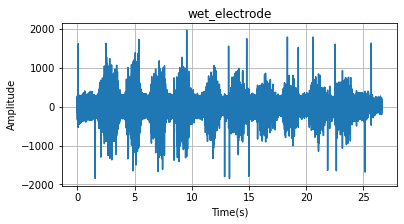

In [25]:
wet_signal, wet_framerate, wet_nframes = read_wave("实验1-干01.wav")
wet_signal_norm = normalize_wave(wet_signal,"statistic")
plot_wave(wet_signal, wet_framerate, "wet_electrode")

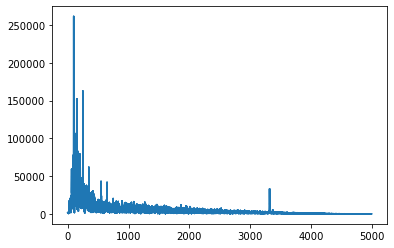

In [9]:
wet_fft, freq_Hz = fft_wave(wet_signal,[0,1],wet_framerate)

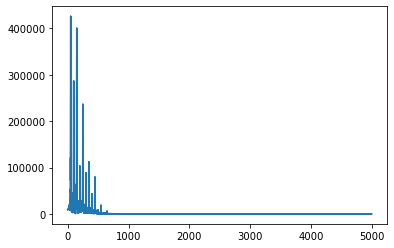

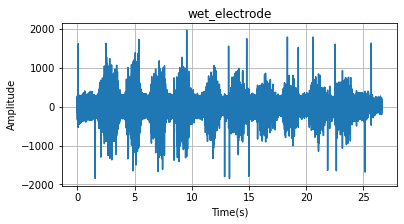

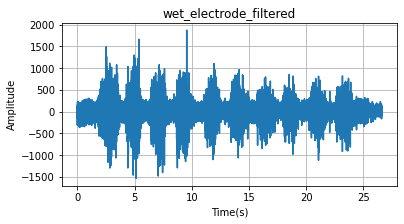

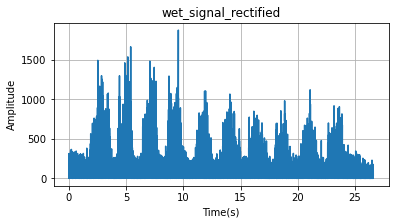

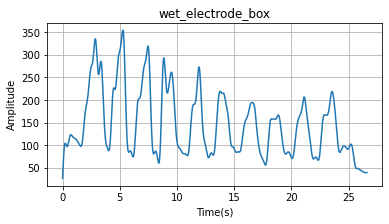

In [26]:
wet_signal_filtered = bandpass_filter(wet_signal, wet_framerate, 20, 450)
wet_signal_rectified = rectified(wet_signal_filtered)
wet_signal_box = lowpass_filter(wet_signal_rectified,wet_framerate, 2)

fft_wave(wet_signal_filtered,[0,1],wet_framerate)
plot_wave(wet_signal, wet_framerate, "wet_electrode")
plot_wave(wet_signal_filtered, wet_framerate, "wet_electrode_filtered")
plot_wave(wet_signal_rectified, wet_framerate, "wet_signal_rectified")
plot_wave(wet_signal_box, wet_framerate, "wet_electrode_box")

In [48]:
def wave_peaks(signal, framerate, peak_heigh):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    peaks = sp.signal.find_peaks(wet_signal_box,height=peak_heigh)
    
#     plt.figure(figsize=(6, 3))
#     plt.plot(time, signal)
#     for i in peaks[0]:
#         plt.scatter(time[i], signal[i])
#     plt.xlabel("Time(s)")
#     plt.ylabel("Amplitude")
#     plt.grid('on')
#     plt.show()
    
    return peaks[0]

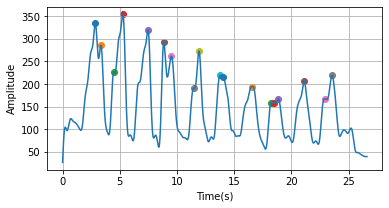

array([ 28603,  33486,  44821,  52678,  74645,  88456,  95108, 114748,
       119224, 137736, 140340, 165818, 182538, 184493, 188466, 211104,
       228972, 235439])

In [38]:
wave_peaks(wet_signal_box, wet_framerate, 150)

In [49]:
def SNR(signal, framerate, peak_heigh, rest_interval):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    signal_peaks_index = wave_peaks(signal, framerate, peak_heigh)
    
    start_rest, end_rest = rest_interval
    rest_signal = signal[(time>=start_rest) & (time<=end_rest)]
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(time, signal)
    for i in signal_peaks_index:
        plt.scatter(time[i], signal[i])
    plt.fill_between(rest_interval,np.min(signal),peak_heigh,color="grey")
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.grid('on')
    plt.show()
    
    
    signal_mean_amp = np.mean(signal[signal_peaks_index])
    noise_mean_amp = np.mean(rest_signal)
    
    SNR = (signal_mean_amp/noise_mean_amp)**2
    return SNR

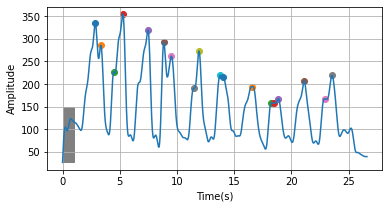

5.1755170257986896

In [50]:
SNR(wet_signal_box, wet_framerate, 150, [0,1])